## Scouting Classification with Machine Learning

### Business Problem 

Predicting which class (average, highlighted) players are according to the scores given to the characteristics of the football players watched by the Scouts.

### Dataset

The data set consists of information from Scoutium, which includes the features and scores of the football players evaluated by the scouts according to the characteristics of the footballers observed in the matches.

##### Variables

###### scoutium_attributes.csv

task_response_id : The set of a scout's assessments of all players on a team's roster in a match
    
match_id : The id of the relevant match
    
evaluator_id : The id of the evaluator(scout)
    
player_id : The id of the relevant player
    
position_id : The id of the position played by the relevant player in that match  
    
1: Goalkeeper 

2: Stopper   

3: Right Back   

4: Left Back  

5: Center Defensive Midfielder

6: Center Midfielder

7: Rightwinger

8: Leftwinger

9: Center Attacking Midfielder

10: Forward
    
analysis_id : A set containing a scout's attribute evaluations of a player in a match
    
attribute_id : The id of each attribute the players were evaluated for.
    
attribute_value : Value (points) given by a scout to a player's attribute

###### scoutium_potential_labels.csv

task_response_id : The set of a scout's assessments of all players on a team's roster in a match

match_id : The id of the relevant match

evaluator_id : The id of the evaluator(scout)

player_id : The id of the relevant player

potential_label : Label indicating the final decision of a scout regarding a player in a match. (target variable)

### Required Library and Functions

In [2]:
import pandas as pd
pd.set_option('display.max_columns', None)
from sklearn.model_selection import *
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import cross_val_predict
import pandas as pd
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)


In [3]:
df = pd.read_csv("/Users/cagladeniz/PycharmProjects/Miuul/Machine Learning/Dataset/scoutium_attributes.csv", sep=";")


In [4]:
df.head()


,task_response_id,match_id,evaluator_id,player_id,position_id,analysis_id,attribute_id,attribute_value
0,4915,62935,177676,1361061,2,12818495,4322,56.000
1,4915,62935,177676,1361061,2,12818495,4323,56.000
2,4915,62935,177676,1361061,2,12818495,4324,67.000
3,4915,62935,177676,1361061,2,12818495,4325,56.000
4,4915,62935,177676,1361061,2,12818495,4326,45.000


In [5]:
df.shape


(10730, 8)

In [6]:
df2 = pd.read_csv("/Users/cagladeniz/PycharmProjects/Miuul/Machine Learning/Dataset/scoutium_potential_labels.csv", sep=";")


In [7]:
df2.head()


,task_response_id,match_id,evaluator_id,player_id,potential_label
0,4915,62935,177676,1361061,average
1,4915,62935,177676,1361626,highlighted
2,4915,62935,177676,1361858,average
3,4915,62935,177676,1362220,highlighted
4,4915,62935,177676,1364951,highlighted


In [8]:
df2.shape


(322, 5)

##### Combine the csv files we have read using the merge function. ("task_response_id", 'match_id', 'evaluator_id' "player_id" perform the merge operation over 4 variables.)

In [9]:
dff = pd.merge(df, df2, how='left', on=["task_response_id", 'match_id', 'evaluator_id', "player_id"])


In [10]:
dff.head()

,task_response_id,match_id,evaluator_id,player_id,position_id,analysis_id,attribute_id,attribute_value,potential_label
0,4915,62935,177676,1361061,2,12818495,4322,56.000,average
1,4915,62935,177676,1361061,2,12818495,4323,56.000,average
2,4915,62935,177676,1361061,2,12818495,4324,67.000,average
3,4915,62935,177676,1361061,2,12818495,4325,56.000,average
4,4915,62935,177676,1361061,2,12818495,4326,45.000,average


##### Remove the Keeper (1) class in position_id from the dataset

In [16]:
dff = dff[dff["position_id"] != 1]

##### Remove the below_average class in the potential_label from the dataset (the below_average class makes up 1% of the entire dataset)

In [17]:
dff = dff[dff["potential_label"] != "below_average"]

##### Create a table from the data set you created using the "pivot_table" function. Manipulate this pivot table with one player per row.

##### Create the pivot table with "player_id", "position_id" and "potential_label" in the index, "attribute_id" in the columns and "attribute_value" in the values given by the scouts to the players.

In [18]:
pt = pd.pivot_table(dff, values="attribute_value", columns="attribute_id", index=["player_id","position_id","potential_label"])


##### Get rid of the index error by using the "reset_index" function and convert the names of the "attribute_id" columns to strings.

In [19]:
pt = pt.reset_index(drop=False)


In [20]:
pt.columns = pt.columns.map(str)


##### Express the “potential_label” categories (average, highlighted) numerically using the Label Encoder function.

In [21]:
le = LabelEncoder()
pt["potential_label"] = le.fit_transform(pt["potential_label"])

##### Assign the numeric variable columns to a list named “num_cols”.

In [22]:
num_cols = pt.columns[3:]


##### Apply standardScaler to scale the data in all the "num_cols" variables you save.

In [23]:
scaler = StandardScaler()
pt[num_cols] = scaler.fit_transform(pt[num_cols])

### Modelling

Develop a machine learning model that predicts the potential tags of football players with minimum error from the data set we have.

In [24]:
y = pt["potential_label"]
X = pt.drop(["potential_label", "player_id"], axis=1)

In [25]:
models = [('LR', LogisticRegression()),
                   ('KNN', KNeighborsClassifier()),
                   ("SVC", SVC()),
                   ("CART", DecisionTreeClassifier()),
                   ("RF", RandomForestClassifier()),
                   ('Adaboost', AdaBoostClassifier()),
                   ('GBM', GradientBoostingClassifier()),
                   ('XGBoost', XGBClassifier(use_label_encoder=False, eval_metric='logloss')),
                   ('CatBoost', CatBoostClassifier(verbose=False)),
              ("LightGBM", LGBMClassifier())]



for name, model in models:
    print(name)
    for score in ["roc_auc", "f1", "precision", "recall", "accuracy"]:
        cvs = cross_val_score(model, X, y, scoring=score, cv=10).mean()
        print(score+" score:"+str(cvs))


/Users/cagladeniz/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


LR
roc_auc score:0.8452886002886002
f1 score:0.5684648684648684
precision score:0.7738095238095238
recall score:0.49000000000000005
accuracy score:0.8525132275132276
KNN
roc_auc score:0.7256998556998557
f1 score:0.4278571428571428
precision score:0.775
recall score:0.30999999999999994
accuracy score:0.8449735449735449
SVC


/Users/cagladeniz/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/cagladeniz/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/cagladeniz/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/cagladeniz/opt/anaconda3/lib/python3.9/site-packages/sklearn

roc_auc score:0.8439105339105339
f1 score:0.03333333333333334
precision score:0.1
recall score:0.02
accuracy score:0.797089947089947
CART


/Users/cagladeniz/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/cagladeniz/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/cagladeniz/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/cagladeniz/opt/anaconda3/lib/python3.9/site-packages/sklearn

roc_auc score:0.7385497835497835
f1 score:0.5421733821733822
precision score:0.5839285714285715
recall score:0.5733333333333333
accuracy score:0.8265873015873015
RF
roc_auc score:0.8991883116883116
f1 score:0.5637301587301586
precision score:0.8833333333333334
recall score:0.45666666666666667
accuracy score:0.8746031746031747
Adaboost
roc_auc score:0.8647474747474746
f1 score:0.5999062049062049
precision score:0.7771428571428571
recall score:0.56
accuracy score:0.8560846560846562
GBM
roc_auc score:0.8821356421356421
f1 score:0.5884920634920634
precision score:0.8200000000000001
recall score:0.5233333333333333
accuracy score:0.8634920634920634
XGBoost


/Users/cagladeniz/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/Users/cagladeniz/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/Users/cagladeniz/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/Users/cagladeniz/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/Users/cagladeniz/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` i

roc_auc score:0.8558080808080808


/Users/cagladeniz/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/Users/cagladeniz/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/Users/cagladeniz/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/Users/cagladeniz/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/Users/cagladeniz/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` i

f1 score:0.611030081030081


/Users/cagladeniz/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/Users/cagladeniz/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/Users/cagladeniz/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/Users/cagladeniz/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/Users/cagladeniz/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` i

precision score:0.7397619047619048


/Users/cagladeniz/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/Users/cagladeniz/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/Users/cagladeniz/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/Users/cagladeniz/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/Users/cagladeniz/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` i

recall score:0.5766666666666665


/Users/cagladeniz/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/Users/cagladeniz/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/Users/cagladeniz/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/Users/cagladeniz/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/Users/cagladeniz/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` i

accuracy score:0.8563492063492063
CatBoost
roc_auc score:0.9040981240981241
f1 score:0.5937662337662338
precision score:0.93
recall score:0.47000000000000003
accuracy score:0.8817460317460318
LightGBM
roc_auc score:0.8982034632034631
f1 score:0.6632539682539682
precision score:0.8071428571428572
recall score:0.5933333333333333
accuracy score:0.8817460317460318


### Feature Engineering

In [26]:
def plot_importance(model, features, num=len(X), save=False):

    feature_imp = pd.DataFrame({"Value": model.feature_importances_, "Feature": features.columns})
    plt.figure(figsize=(10, 10))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False)[0:num])
    plt.title("Features")
    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig("importances.png")

In [27]:
model = LGBMClassifier()


In [28]:
model.fit(X, y)


LGBMClassifier()

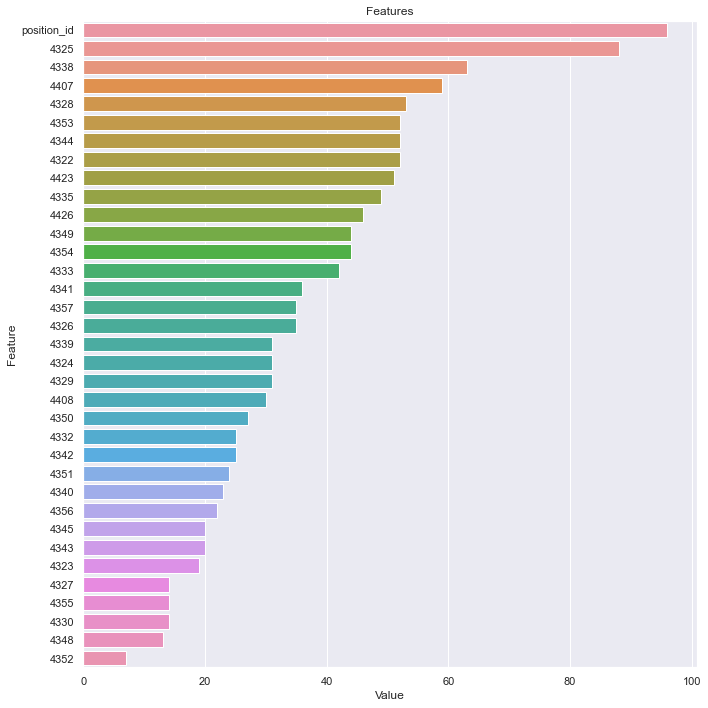

In [29]:
plot_importance(model, X)
